In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
import emcee
import scipy.stats
import corner

In [2]:
data= np.load('transient.npy')

First, always start with a quick look at the data

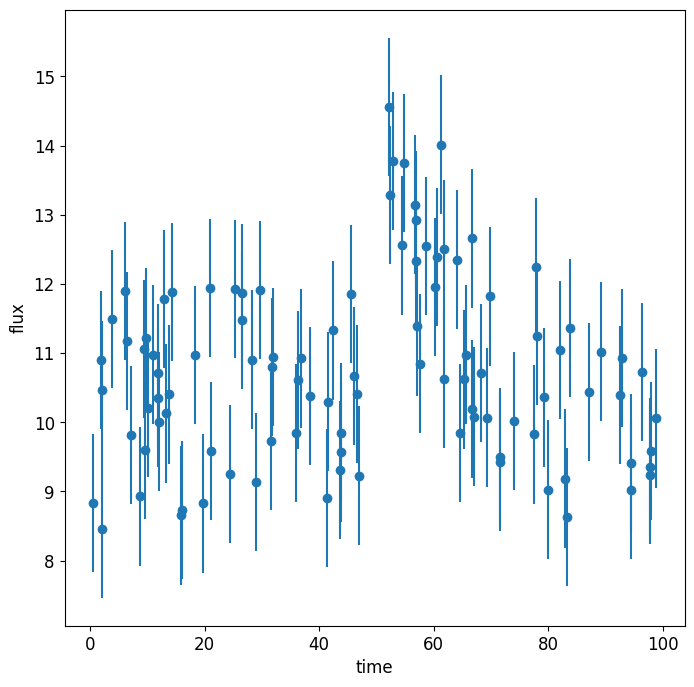

In [3]:
t,y,yerr=data.T
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

In [4]:
def burst(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))

Now let's try to fit this by hand. This should not be used for any science, it's just to get a feeling on the numbers we should expect.

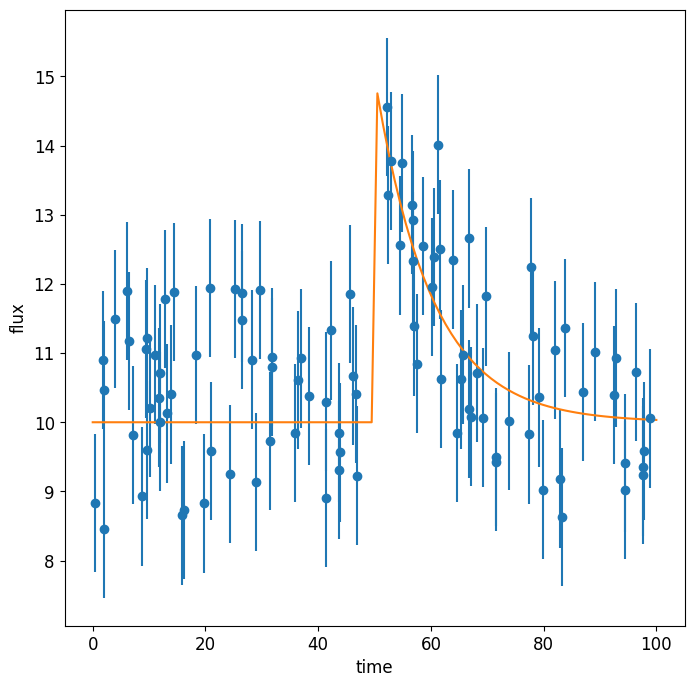

In [5]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1


theta_quick= np.array([A_quick,b_quick,t0_quick,alpha_quick])
ygrid =  burst(theta_quick,tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid);

I'll go for emcee here. This tutorial is very useful... https://emcee.readthedocs.io/en/stable/tutorials/line/



In [6]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [7]:
def LogLikelihood(theta, data, model=burst):
    x, y, sigma_y = data.T
    y_fit = model(theta, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

## prior is proportional to 1/alpha
def Logprior(theta):
    A,b,t0,alpha=theta 
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf
                   
def LogPosterior(theta,data, model=burst):
    return LogLikelihood(theta,data, model) + Logprior(theta)


In [17]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**

# initialize theta 

# These are some of things I tried without much sucess...
#np.random.seed(0)
#starting_guesses = np.random.random((nwalkers, ndim))

#print(starting_guesses.shape)

#starting_guesses =  np.array( [scipy.stats.uniform(loc=Amin,scale=Amax-Amin).rvs(size=nwalkers), \
#                   scipy.stats.uniform(loc=bmin,scale=bmax-bmin).rvs(size=nwalkers), \
#                   scipy.stats.uniform(loc=t0min,scale=t0max-t0min).rvs(size=nwalkers), \
#                   scipy.stats.loguniform.rvs(alphamin,alphamax,size=nwalkers)]).T


# Here I use my dirty fit from above to initialize the walkers. 
# You can do this better and first perform a maximum likelihood estimate.
starting_guesses = theta_quick + 1e-1* np.random.randn(nwalkers, ndim)

print(starting_guesses.shape)

(20, 4)


Ok now the actual sampling

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, burst])
sampler.run_mcmc(starting_guesses, nsteps);

Let's have a look at the chains

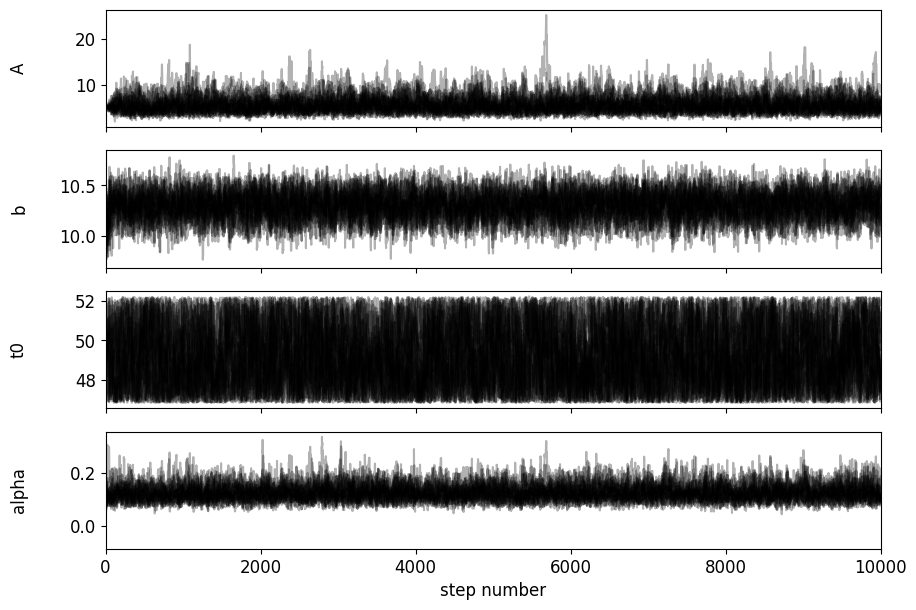

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


Get the autocorrelation lenght in each dimension

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[70.83447826 57.83629594 75.79411028 71.17628544]


Set the initial burn in to 3 times the largest correlation lenght. Thin the chain by the largerst correlation lenght.

In [12]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(2600, 4)


This is the final product of the analysis:

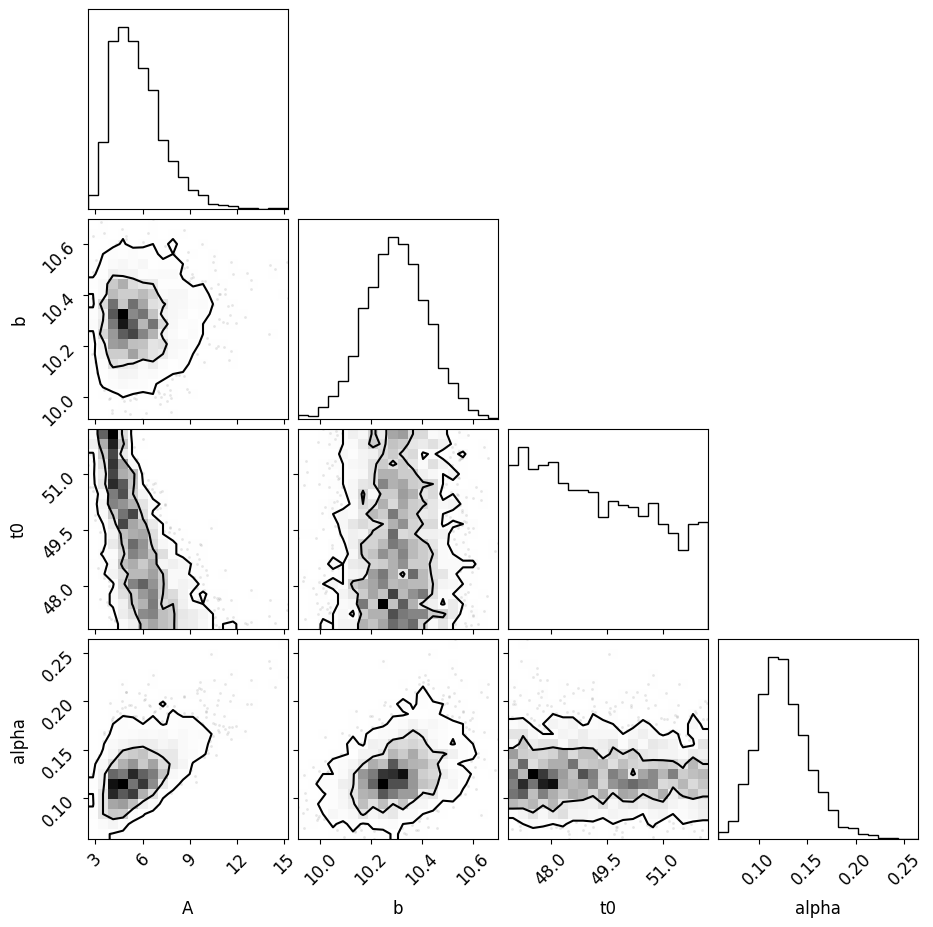

In [13]:
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95]
);

Now let's pick some samples and plot the corresponding models on top of the data

In [14]:
chosen_samples= flat_samples[np.random.choice(len(flat_samples),size=30)]

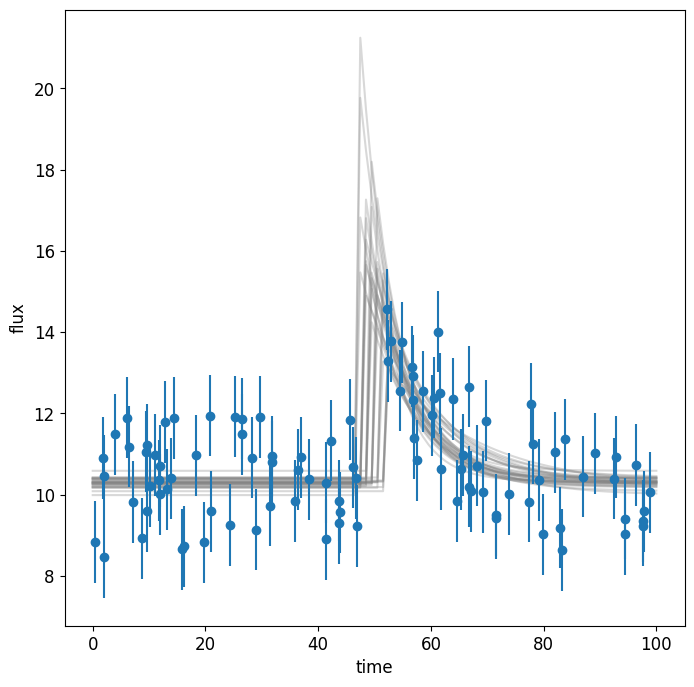

In [15]:
tgrid=np.linspace(0,100,100)

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

Nice!

Some summary statistics

In [16]:
for i,l in enumerate(labels):
    low,med, up = np.percentile(flat_samples[:,i],[5,50,95]) 
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

A   5.427600247842388 +3.3015667164894325 -1.8291502262604098
b   10.299636318764067 +0.20535338417853843 -0.19649448557413685
t0   49.10338585624973 +2.75024865637522 -2.048897943277339
alpha   0.12259364722764499 +0.051105356967975274 -0.037400571884092904
